In [1]:
pip install pytorch-msssim

In [2]:
#Importing the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from torchvision import models,datasets,transforms

from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
from pytorch_msssim import ssim
import pickle

In [3]:
#Checking if a GPU with CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#Creating a custom dataset class that generates the noisy counterpart of the clean image and returns both of them
class CustomDataset(Dataset):
  def __init__(self,dir_name,train_flag):
    """
    train_flag is True for the Train dataset and False for the evaluation dataset
    """
    super().__init__()
    #Defining the transforms for the train and test datasets
    self.test_transform = transforms.Compose([transforms.ToTensor()])

    self.train_flag = train_flag

    #Downloading the train and test datasets
    if train_flag:
      pfile = open(dir_name, 'rb')     #opening the pickle file
      self.dataset = pickle.load(pfile) #Reading the tensors from the pickle file
      pfile.close() #Closing the pickle file


  def __len__(self):
    if self.train_flag:
      return len(self.dataset)

    else:
      return 1

  def __getitem__(self, index):
    if self.train_flag:
      img = self.dataset[index] #of shape (3,40,40)
      return img

    else:
      im1 = Image.open("/content/drive/MyDrive/R2R_ML/an_image/test/Sony_4-5_125_3200_plant_13_mean.JPG").convert("RGB") #PIL object
      clean_img = self.test_transform(im1) #of shape (3,h,w)

      im2 = Image.open("/content/drive/MyDrive/R2R_ML/an_image/test/Sony_4-5_125_3200_plant_13_real.JPG").convert("RGB") #PIL object
      noisy_img = self.test_transform(im2) #of shape (3,h,w)
      return clean_img, noisy_img



In [5]:
#Defining a Block of the DnCNN
class Block(nn.Module):
  def __init__(self,k=3,p=1,c=64):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=c,out_channels=c,kernel_size=k,padding=p,bias=False) #same padding convolution
    self.norm = nn.BatchNorm2d(c) #batch normalization
    self.relu = nn.ReLU(inplace=True) #activation function

  def forward(self,x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.relu(x)
    return x


In [6]:
#Defining the DnCNN model
class DCNN(nn.Module):
  def __init__(self,k=3,p=1,c=64,l=17,in_c=1):
    super().__init__()
    layers = [nn.Conv2d(in_channels=in_c,out_channels=c,kernel_size=k,padding=p,bias=False), #First same padding convolution layer
              nn.ReLU(inplace=True)]
    layers.extend([Block(k,p,c) for _ in range(l-2)]) #Adding all the "Blocks" to the model
    layers.append(nn.Conv2d(in_channels=c,out_channels=in_c,kernel_size=k,padding=p,bias=False)) #Last same padding convolution layer

    self.all = nn.Sequential(*layers)

  def forward(self,x):
    out = self.all(x)
    return x-out


In [7]:
def test_baseline(criterion,device,test_loader):
  """
  criterion is the function used to compute PSNR
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  """

  loop = tqdm(test_loader)
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      clean_pred = torch.clamp(noisy,min=0.0,max=1.0)
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)

      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [8]:
def test_unsupervised(criterion,model,device,test_loader,alpha,sigma,T):
  """
  criterion is the function used to compute PSNR
  model is the trained unsupervised denoiser model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  sigma is the noise level
  alpha is the constant of 20
  T is the number of forward processes averaged to reduce the effect of recorruption
  """

  model.eval()
  loop = tqdm(test_loader)  #Used to visualize the progress in testing
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      out = torch.zeros(clean.shape).to(device)
      for _ in range(T):
        noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
        noisy_main = noisy+alpha*noise
        out += model(noisy_main)

      clean_pred = torch.clamp(out/T,min=0.0,max=1.0)

      #Computing PSNR
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)
      #Computing SSIM
      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [9]:
def display(test_set,index,model_unsup,alpha,sigma,T):
  """
  test_set is the contains all the images of the test set
  index is a number to select an image from the test set
  model_unsup is the trained unsupervised (R2R) denoiser
  alpha is a number
  sigma is the noise level
  T is the number of times the noisy image is passed through the unsupervised denoiser to generate clean image

  """
  clean, noisy = test_set[index]
  clean, noisy = clean.to(device), noisy.to(device)

  #For unsupervised Denoising
  model_unsup.eval()
  out_unsup = torch.zeros(noisy.shape).unsqueeze(0).to(device)

  with torch.no_grad():
    for _ in range(T):
      noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
      noisy_main = noisy+alpha*noise
      out_unsup += model_unsup(noisy_main.unsqueeze(0))

  clean_pred_unsup = torch.clamp(out_unsup/T,min=0.0,max=1.0)

  fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(120,80))

  axes[0].imshow(clean.cpu().squeeze().permute((1,2,0)))
  axes[0].axis("off")
  axes[0].set_title("Ground Truth Clean Image",fontsize=80)

  axes[1].imshow(noisy.cpu().squeeze().permute((1,2,0)))
  axes[1].axis("off")
  axes[1].set_title("Noisy Image",fontsize=80)

  axes[2].imshow(clean_pred_unsup.cpu().squeeze().detach().permute((1,2,0)))
  axes[2].axis("off")
  axes[2].set_title("Unsupervised Denoised Image",fontsize=80)

  plt.show()

In [10]:
criterion_test = nn.MSELoss(reduce=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
#Loading all the unsupervised models
model_unsup = DCNN(in_c=3).to(device)
model_unsup.load_state_dict(torch.load("/content/Unsupervised23_32.23_0.4434824560303241.pt"))

<All keys matched successfully>

In [12]:
#Defines the loaders for the train and test set
test_set = CustomDataset("",False)
test_loader = DataLoader(test_set,batch_size=1,shuffle=False,num_workers=1)
print(len(test_set))

1


In [13]:
test_baseline(criterion_test,device,test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


 The PSNR is 31.182998657226562 and the SSIM is 0.9075967669487


In [14]:
test_unsupervised(criterion_test,model_unsup,device,test_loader,alpha=20,sigma=0.4434824560303241,T=50)

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


 The PSNR is 32.226924896240234 and the SSIM is 0.9492702484130859


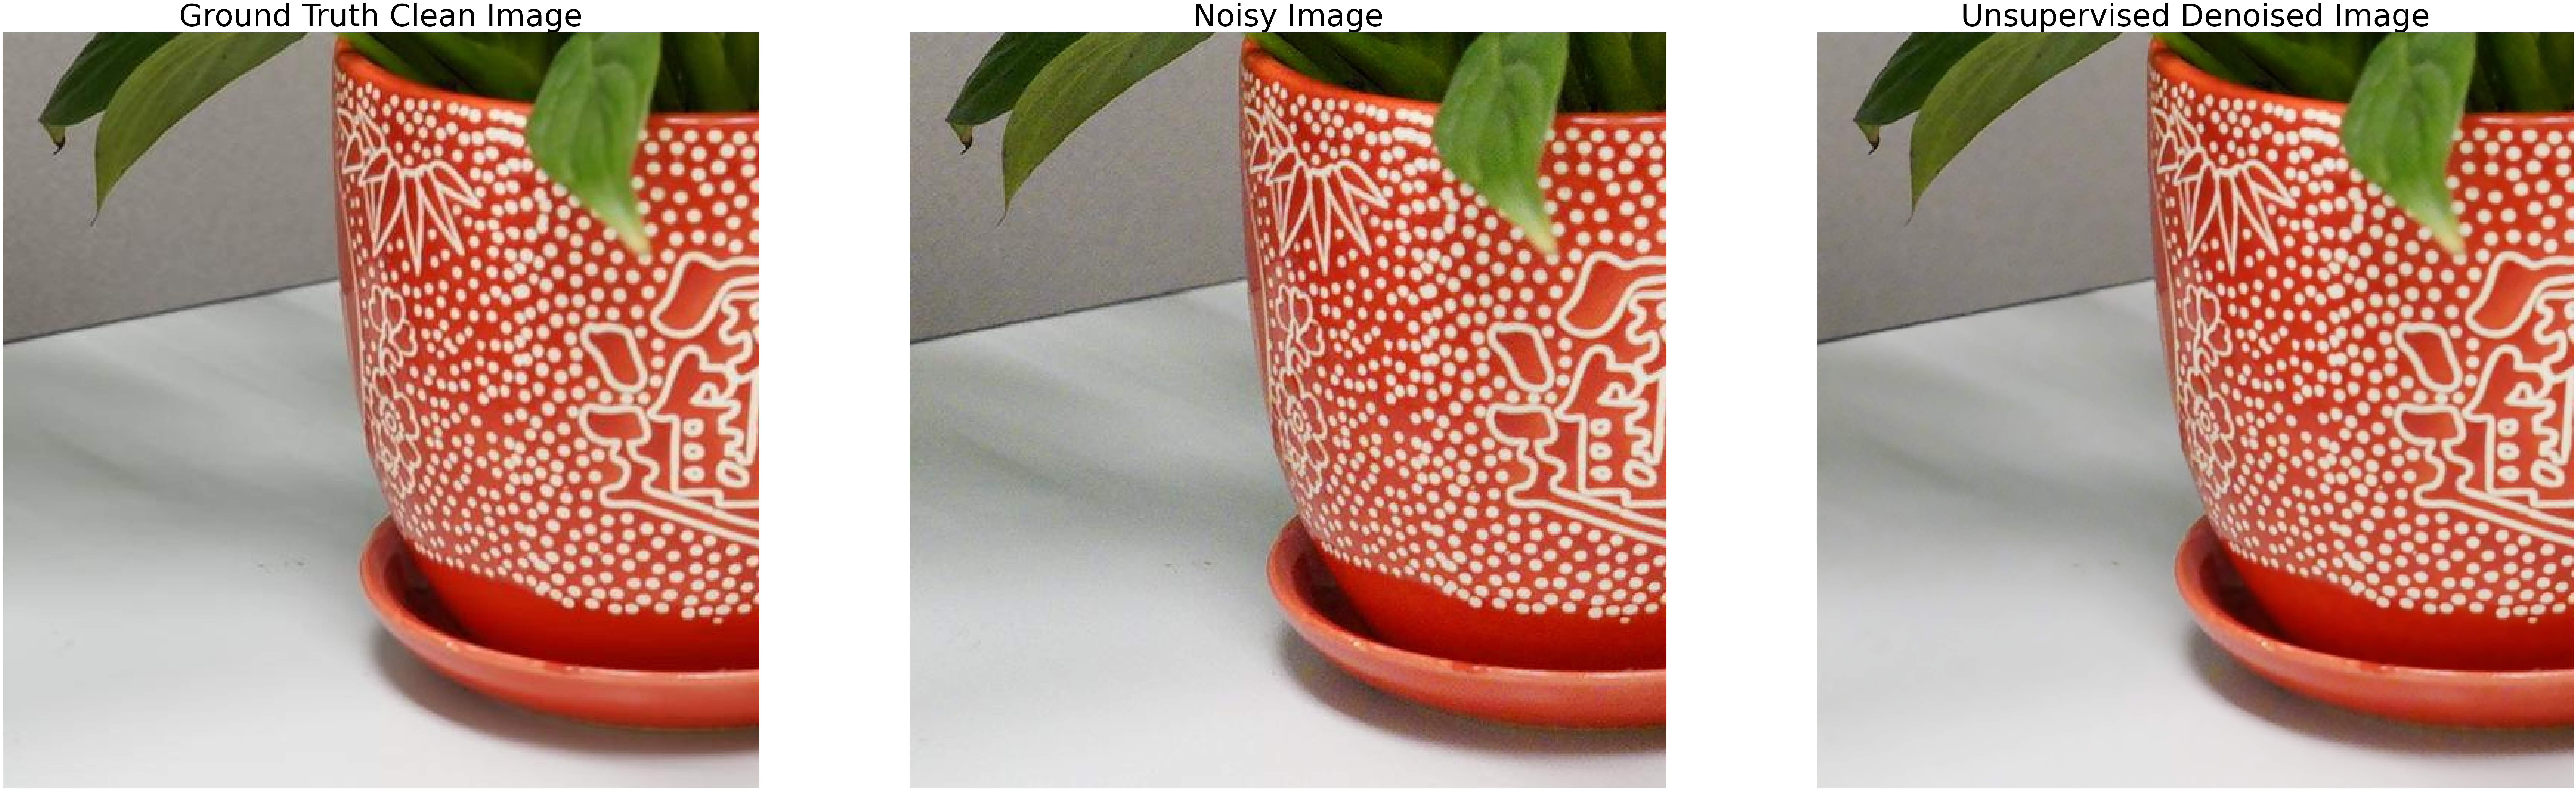

In [15]:
display(test_set,index=0,model_unsup=model_unsup,alpha=20,sigma=0.4434824560303241,T=50)